# Functional data and importing data

Export tensile stress-strain data from the MI_Training database, and fit a curve to the exported data. Create a new record using parameter values extracted from the fitted curve, and upload this record to the database.

This example demonstrates:

- Browsing for records
- Extracting functional data from a Granta MI database
- Importing a new record to a Granta MI database

## Create a Granta MI Session

Import the GRANTA_MIScriptingToolkit package, and create a connection to a Granta MI server.

In [1]:
import datetime
import sys
import GRANTA_MIScriptingToolkit as gdl

session = gdl.GRANTA_MISession('http://my.server.name/mi_servicelayer', autoLogon=True)

## Browse for records

Browse for a record located within the Tensile Statistical Data table in the MI_Training database.

Set the folder path for the record to browse to as: High Alloy Steel / AMS 6520 / Plate / Room Temperature °F.

In [2]:
dbKey = 'MI_Training'
table = 'Tensile Statistical Data'
folderPath = """High Alloy Steel/AMS 6520/Plate/Room Temperature °F"""

Get the root node of the table of interest.

In [3]:
tableReference = gdl.TableReference(DBKey = dbKey, name = table)
treeRecord = session.browseService.GetRootNode(gdl.GetRootNode(tableReference)).rootNode

Find the record of interest, *AMS 6520, Plate, Room Temperature °F*.

In [4]:
folders = folderPath.split('/')

for folder in folders:
    treeRecords = session.browseService.GetChildNodes(gdl.GetChildNodes(parent=treeRecord.recordReference)).treeRecords
    treeRecord = next((r for r in treeRecords if r.shortName == folder), None)
    if treeRecord:
        print("Found treeRecord: {0}".format(treeRecord.shortName))
    else:
        print("Unable to find folder: {0}".format(folder))
        sys.exit()

Found treeRecord: High Alloy Steel
Found treeRecord: AMS 6520


Found treeRecord: Plate
Found treeRecord: Room Temperature °F


## Exporting data

Export *Tensile Response (11 axis)* data from the record of interest.

In [5]:
attribute = 'Tensile Response (11 axis)'

partialTableRef = gdl.PartialTableReference(tableName = table)
attrRef = gdl.AttributeReference(name = attribute, DBKey = dbKey, partialTableReference = partialTableRef)
request = gdl.GetRecordAttributesByRefRequest(recordReferences = [treeRecord.recordReference], attributeReferences = [attrRef])

data = session.dataExportService.GetRecordAttributesByRef(request).recordData[0]

Check the data type of the *Tensile Response (11 axis)* attribute is FLOAT_FUNCTIONAL_SERIES.

In [6]:
value = data.attributeValues[0]
print("Attribute Name: {0.attributeName}, Type {0.dataType}".format(value))

Attribute Name: Tensile Response (11 axis), Type FLOAT_FUNCTIONAL_SERIES


Extract the data from each curve into a list.

In [7]:
graph = value.floatFunctionalSeriesDataType.graph
series = graph.series

curves = []

for curve in series:
    points = curve.XYPoints.XYPoints
    x = [point.parameterValue.numericValue for point in points]
    y = [point.Y for point in points]
    curves.append([x,y])
    
print(curves)

[[[0.0, 0.884463, 0.889755, 0.890251, 0.890748, 0.891246, 0.922673, 0.937986, 0.96068, 0.986228, 1.00829, 1.02755, 1.0414, 1.05956, 1.07409, 1.08701, 1.11642, 1.14737, 1.17464, 1.20351, 1.23038], [0.0, 1731.86, 1733.01, 1733.87, 1734.72, 1735.58, 1786.9, 1809.62, 1840.22, 1870.26, 1892.73, 1910.05, 1921.33, 1934.84, 1944.71, 1952.89, 1969.64, 1984.99, 1996.96, 2008.33, 2017.92]]]


Plot the curves using the matplotlib package.

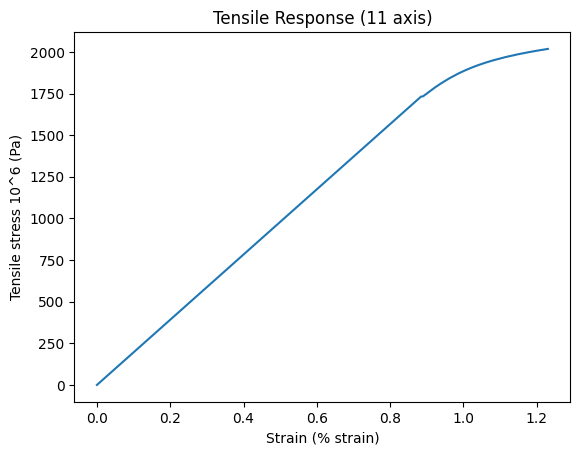

In [8]:
import matplotlib.pyplot as plt

x_label = '{param.name} ({param.unit.unitSymbol})'.format(param = graph.XAxisParameter)
y_label = 'Tensile stress 10^6 (Pa)'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Tensile Response (11 axis)')

for curve in curves:
    ax.plot(curve[0], curve[1])

Fit a Ramberg-Osgood function to the data.

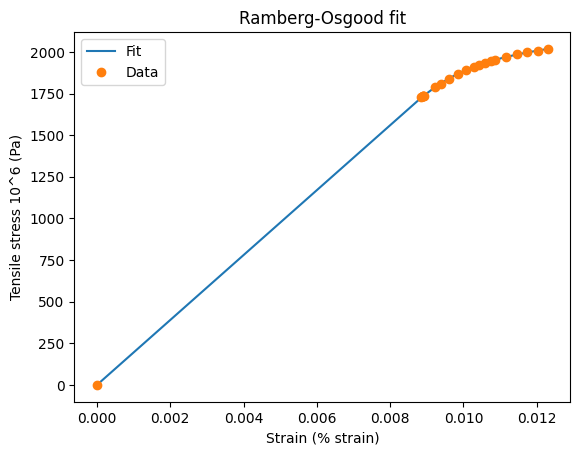

In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np


def ramberg_osgood(p, stress):
    return (stress/p[0])*(1.0 + p[1]*(stress/p[2])**(p[3]-1))


def error_function(p, stress, strain):
    return ramberg_osgood(p, stress) - strain


strain = 0.01 * np.array(curves[0][0])
stress = np.array(curves[0][1])

p0 = (2.0e5, 0.0, 1.0, 24.0)

plsq = leastsq(error_function, p0[:], args=(stress, strain))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

ax.plot(ramberg_osgood(plsq[0], stress), stress, label='Fit')
ax.plot(strain, stress, marker='o', linestyle=' ', label='Data')

ax.set_title('Ramberg-Osgood fit')
ax.legend()

## Importing data

Create a new record using the attribute values for Young's modulus obtained from the fitted curve, and import this record into the database.

Identify the folder to upload the new record to. Browse the record tree to get the record reference for that folder.

In [10]:
importDBKey = 'MI_Training'
importTableName = 'Tensile Statistical Data'
importFolderPath = """High Alloy Steel/AMS 6520"""
now = datetime.datetime.now()
currentTime = now.strftime("%d/%m/%Y %H:%M:%S")
importRecordName = f"AMS 6520 - With Fitted Data @{currentTime}"

importFolders = importFolderPath.split('/')

importTableReference = gdl.TableReference(DBKey=importDBKey, name=importTableName)
treeRecord = session.browseService.GetRootNode(gdl.GetRootNode(table=importTableReference)).rootNode

for folder in importFolders:
    treeRecords = session.browseService.GetChildNodes(gdl.GetChildNodes(parent=treeRecord.recordReference)).treeRecords
    treeRecord = next((r for r in treeRecords if r.shortName == folder), None)
    if treeRecord:
        print("Found treeRecord folder: {0}".format(treeRecord.shortName))
    else:
        print("Unable to find import folder: {0}".format(folder))
        sys.exit()

Found treeRecord folder: High Alloy Steel
Found treeRecord folder: AMS 6520


Define the record attribute to include in the new record.

In [11]:
modulusAttributeReference = gdl.AttributeReference(
    name="Young's Modulus (11-axis)",
    DBKey=importDBKey,
    partialTableReference=gdl.PartialTableReference(tableName = importTableName)
)

Set values and units for the attributes of the new record.

In [12]:
fittedEValue = plsq[0][0]
modulusValue = gdl.PointValueWithParameters(value=fittedEValue)

modulusPointValue = gdl.PointDataType(unitSymbol='psi', points=[modulusValue])

importModulusValue = gdl.ImportAttributeValue(attributeReference=modulusAttributeReference, pointDataValue=modulusPointValue)

Create a reference to the subset that the new record will be added to.

In [13]:
subsetReference = gdl.SubsetReference(
    name='Statistical Test Data',
    DBKey=importDBKey,
    partialTableReference=gdl.PartialTableReference(tableName=importTableName)
)

Import the record to the Granta MI database.

In [14]:
importRecord = gdl.ImportRecord(recordName=importRecordName,
                                existingRecord=treeRecord.recordReference,
                                subsetReferences=[subsetReference],
                                importAttributeValues=[importModulusValue])

setRecordAttributesRequest = gdl.SetRecordAttributesRequest(importRecords=[importRecord])
setRecordAttributesResponse = session.dataImportService.SetRecordAttributes(setRecordAttributesRequest)

for record in setRecordAttributesResponse.recordsImported:
    print("Imported record {0} to Granta MI database".format(record.shortName))

Imported record AMS 6520 - With Fitted Data @01/09/2023 15:57:54 to Granta MI database
